# Reconstrucción local del análisis de Smart Core + Pupil Labs

Este notebook tiene como objetivo reconstruir localmente el análisis completo del experimento **Smart Core**, utilizando como insumos:

- Los datos generados por la app  
  - Archivo: `experimento_<ID>.xlsx`  
  - Hoja: `Resumen`

- Los archivos exportados por Pupil Labs para cada participante:
  - `gaze_positions.csv`
  - `world_timestamps.npy`
  - `fixations.csv`
  - `fixation_report.csv`
  - `blinks.csv` *(opcional)*
  - `blink_detection_report.csv` *(opcional)*
  - `pupil_positions.csv` *(opcional)*
  - `export_info.csv` *(opcional)*

---

## 🎯 Objetivo del notebook

Crear un entorno controlado donde podamos:

1. **Cargar todos los archivos de manera robusta**
   - Normalización de nombres de columnas
   - Manejo de diferentes codificaciones de texto
   - Validación de contenido vacío o corrupto

2. **Preparar y limpiar los datos de gaze**
   - Ordenar por tiempo
   - Eliminar valores no numéricos
   - Calcular `dt` entre muestras
   - Filtrar por confianza (ej. `< 0.6`, si aplica)

3. **Sincronizar todas las fuentes**
   - Usando `world_timestamps.npy` para convertir frames → tiempo real
   - Usando los intervalos por pantalla definidos en `Frame_inicio` y `Frame_fin` del Excel (`Resumen`)
   - Usando las AOIs que vienen como JSON en la hoja `Resumen`

Con esto se busca reconstruir:

- Gaze *framewise* (timestamp por timestamp)
- Atención por AOI por pantalla
- Atención por modo de presentación
- Tasa de parpadeo
- Métricas globales del participante

In [4]:
from pathlib import Path

# ==========================
# CONFIGURACIÓN BÁSICA
# ==========================

PARTICIPANT_NAME = "Jake Windham"
PARTICIPANT_TIMESTAMP = "20251202_124710"

# Ruta REAL (tal como la devuelve VS Code)
BASE_DIR = Path(r"C:\Users\salva\Downloads\Jake%20Windham_20251202_124710\Jake%20Windham_20251202_124710")

# Archivo de Excel del experimento
EXPERIMENT_EXCEL = BASE_DIR / f"experimento_{PARTICIPANT_NAME}_{PARTICIPANT_TIMESTAMP}.xlsx"
EXPERIMENT_SHEET = "Resumen"

# Archivos Pupil Labs esperados
PUPIL_FILES = {
    "gaze_positions": "gaze_positions.csv",
    "world_timestamps": "world_timestamps.npy",
    "fixations": "fixations.csv",
    "fixation_report": "fixation_report.csv",
}

print("📂 Carpeta del participante:", BASE_DIR)
print("📄 Archivo Excel:", EXPERIMENT_EXCEL)
print("📁 Archivos Pupil esperados:")
for k, v in PUPIL_FILES.items():
    print(f"  - {k}: {v}")


📂 Carpeta del participante: C:\Users\salva\Downloads\Jake%20Windham_20251202_124710\Jake%20Windham_20251202_124710
📄 Archivo Excel: C:\Users\salva\Downloads\Jake%20Windham_20251202_124710\Jake%20Windham_20251202_124710\experimento_Jake Windham_20251202_124710.xlsx
📁 Archivos Pupil esperados:
  - gaze_positions: gaze_positions.csv
  - world_timestamps: world_timestamps.npy
  - fixations: fixations.csv
  - fixation_report: fixation_report.csv


In [5]:
import pandas as pd
import numpy as np

# ==========================
# FUNCIONES DE CARGA ROBUSTA
# ==========================

def load_csv_safe(path, encodings=("utf-8", "utf-8-sig", "latin-1"), **kwargs):
    """
    Carga un CSV de manera robusta:
    - Verifica existencia
    - Prueba varias codificaciones
    - Maneja errores sin romper el notebook
    """
    path = Path(path)

    if not path.exists():
        print(f"⚠️  No se encontró el archivo CSV: {path.name}")
        return None

    last_error = None
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, **kwargs)
            print(f"✅ CSV cargado: {path.name} (encoding='{enc}', filas={len(df)})")
            return df
        except Exception as e:
            last_error = e
            continue

    print(f"❌ No se pudo leer el CSV {path.name}. Último error:\n{last_error}")
    return None


def load_npy_safe(path):
    """
    Carga un archivo NPY de forma segura.
    """
    path = Path(path)

    if not path.exists():
        print(f"⚠️  No se encontró el archivo NPY: {path.name}")
        return None

    try:
        arr = np.load(path)
        print(f"✅ NPY cargado: {path.name} (shape={arr.shape})")
        return arr
    except Exception as e:
        print(f"❌ Error al cargar NPY {path.name}: {e}")
        return None


def normalize_columns(df):
    """
    Normaliza nombres de columnas:
    - minúsculas
    - sin espacios
    - sin saltos de línea
    """
    if df is None:
        return None

    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("\n", "_")
    )
    return df


In [10]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# ==========================
# 1. CARGA DEL EXCEL DEL EXPERIMENTO
# ==========================

experiment_df = None

if not EXPERIMENT_EXCEL.exists():
    print(f"❌ No se encontró el archivo Excel: {EXPERIMENT_EXCEL}")
else:
    try:
        experiment_df = pd.read_excel(EXPERIMENT_EXCEL, sheet_name=EXPERIMENT_SHEET)
        experiment_df = normalize_columns(experiment_df)
        print(f"✅ Excel cargado correctamente: {EXPERIMENT_EXCEL.name}")
        print(f"   Filas: {len(experiment_df)}, Columnas: {len(experiment_df.columns)}")
    except Exception as e:
        print(f"❌ Error al cargar el Excel: {e}")


# ==========================
# 2. CARGA DE ARCHIVOS PUPIL LABS
# ==========================

pupil_data = {}

for key, filename in PUPIL_FILES.items():
    file_path = BASE_DIR / filename

    if filename.endswith(".csv"):
        df = load_csv_safe(file_path)
        df = normalize_columns(df) if df is not None else None
        pupil_data[key] = df

    elif filename.endswith(".npy"):
        arr = load_npy_safe(file_path)
        pupil_data[key] = arr

    else:
        print(f"ℹ️ Archivo no manejado aún: {filename}")
        pupil_data[key] = None


# ==========================
# 3. Mostrar resumen
# ==========================

print("\n📊 RESUMEN DE ARCHIVOS CARGADOS")
print("══════════════════════════════════")

print("\n📄 Archivo del experimento:")
if experiment_df is None:
    print("   ❌ No cargado")
else:
    print(f"   ✅ Cargado — Filas: {len(experiment_df)}, Columnas: {len(experiment_df.columns)}")

print("\n👁 Archivos Pupil Labs:")
for key, obj in pupil_data.items():
    if obj is None:
        print(f"   - {key}: ❌ No disponible")
    elif isinstance(obj, pd.DataFrame):
        print(f"   - {key}: ✅ DataFrame ({len(obj)} filas)")
    else:
        print(f"   - {key}: ✅ Objeto NPY {type(obj)} con shape {obj.shape}")


✅ Excel cargado correctamente: experimento_Jake Windham_20251202_124710.xlsx
   Filas: 5, Columnas: 47
✅ CSV cargado: gaze_positions.csv (encoding='utf-8', filas=15222)
✅ NPY cargado: world_timestamps.npy (shape=(1792,))
✅ CSV cargado: fixations.csv (encoding='utf-8', filas=272)
✅ CSV cargado: fixation_report.csv (encoding='utf-8', filas=4)

📊 RESUMEN DE ARCHIVOS CARGADOS
══════════════════════════════════

📄 Archivo del experimento:
   ✅ Cargado — Filas: 5, Columnas: 47

👁 Archivos Pupil Labs:
   - gaze_positions: ✅ DataFrame (15222 filas)
   - world_timestamps: ✅ Objeto NPY <class 'numpy.ndarray'> con shape (1792,)
   - fixations: ✅ DataFrame (272 filas)
   - fixation_report: ✅ DataFrame (4 filas)


In [13]:
# Mostrar columnas reales del archivo gaze_positions.csv
gaze = pupil_data.get("gaze_positions")

print("📌 Columnas en gaze_positions:")
print(list(gaze.columns))


📌 Columnas en gaze_positions:
['gaze_timestamp', 'world_index', 'confidence', 'norm_pos_x', 'norm_pos_y', 'base_data', 'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z', 'eye_center0_3d_x', 'eye_center0_3d_y', 'eye_center0_3d_z', 'gaze_normal0_x', 'gaze_normal0_y', 'gaze_normal0_z', 'eye_center1_3d_x', 'eye_center1_3d_y', 'eye_center1_3d_z', 'gaze_normal1_x', 'gaze_normal1_y', 'gaze_normal1_z']


In [14]:
# ==========================
# 5B. LIMPIEZA DEL GAZE (versión correcta Pupil Core)
# ==========================

gaze = pupil_data.get("gaze_positions")

if gaze is None:
    raise ValueError("No se encontró gaze_positions.csv — no se puede continuar.")

gaze_clean = gaze.copy()

# --- 1) Asegurar que gaze_timestamp es numérico ---
if "gaze_timestamp" in gaze_clean.columns:
    gaze_clean["gaze_timestamp"] = pd.to_numeric(gaze_clean["gaze_timestamp"], errors="coerce")
else:
    raise ValueError("El archivo gaze_positions no contiene la columna 'gaze_timestamp'.")

# --- 2) Asegurar que world_index existe ---
if "world_index" not in gaze_clean.columns:
    raise ValueError("El archivo gaze_positions no contiene la columna 'world_index'.")

# --- 3) Ordenar por timestamp ---
gaze_clean = gaze_clean.sort_values("gaze_timestamp").reset_index(drop=True)

# --- 4) Calcular dt ---
gaze_clean["dt"] = gaze_clean["gaze_timestamp"].diff().clip(lower=0, upper=1)
gaze_clean["dt"].fillna(0.016, inplace=True)  # equivalente a ~60FPS

# --- 5) Filtrar por confianza ---
if "confidence" in gaze_clean.columns:
    before = len(gaze_clean)
    gaze_clean = gaze_clean[gaze_clean["confidence"] >= 0.6].reset_index(drop=True)
    after = len(gaze_clean)
    print(f"🔍 Filtrado por confianza >= 0.6 → {before} → {after} filas")
else:
    print("ℹ️ No existe la columna 'confidence'; se omite filtro.")

# --- 6) Resumen ---
print("\n📊 Resumen de gaze limpio (primeras filas):")
display(gaze_clean.head())

print(f"\nTotal de filas después de limpieza: {len(gaze_clean)}")

# Guardamos el DataFrame preparado
gaze_prepared = gaze_clean


🔍 Filtrado por confianza >= 0.6 → 15222 → 14321 filas

📊 Resumen de gaze limpio (primeras filas):


C:\Users\salva\AppData\Local\Temp\ipykernel_29032\1826407524.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gaze_clean["dt"].fillna(0.016, inplace=True)  # equivalente a ~60FPS


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,gaze_normal0_x,gaze_normal0_y,gaze_normal0_z,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016000
1,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003809
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003781
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003945
4,8171.148839,0,1.000000,0.344525,0.561376,8171.1488389999995-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003931



Total de filas después de limpieza: 14321


In [15]:
# ==========================
# 6. SINCRONIZACIÓN GAZE ↔ WORLD TIMESTAMPS
# ==========================

world_ts = pupil_data.get("world_timestamps")

if world_ts is None:
    raise ValueError("world_timestamps.npy no está cargado — no se puede sincronizar gaze.")

gaze_sync = gaze_prepared.copy()

# --- 1) Validar columna world_index ---
if "world_index" not in gaze_sync.columns:
    raise ValueError("El archivo gaze_positions no contiene 'world_index'.")

# --- 2) Convertir world_index a enteros seguros ---
gaze_sync["world_index"] = pd.to_numeric(gaze_sync["world_index"], errors="coerce").astype("Int64")

# --- 3) Crear columna de tiempo real del mundo ---
# world_index → índice dentro de world_ts
# Si un índice está fuera de rango, ponemos NaN

max_idx = len(world_ts) - 1

def safe_world_time(idx):
    if pd.isna(idx):
        return None
    i = int(idx)
    if 0 <= i <= max_idx:
        return float(world_ts[i])
    return None  # fuera de rango

gaze_sync["world_time"] = gaze_sync["world_index"].apply(safe_world_time)

# --- 4) Verificar cuántos puntos quedaron con tiempo válido ---
valid_times = gaze_sync["world_time"].notna().sum()
print(f"⏱️ Timestamps válidos asignados: {valid_times} / {len(gaze_sync)}")

# --- 5) Ordenar por tiempo real ---
gaze_sync = gaze_sync.sort_values("world_time").reset_index(drop=True)

print("\n📊 Resumen de gaze sincronizado:")
display(gaze_sync.head())

gaze_synced = gaze_sync


⏱️ Timestamps válidos asignados: 14321 / 14321

📊 Resumen de gaze sincronizado:


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,gaze_normal0_y,gaze_normal0_z,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt,world_time
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016000,8171.13127
1,8171.157020,0,1.000000,0.352057,0.571332,8171.157015-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004088,8171.13127
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003781,8171.13127
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003945,8171.13127
4,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003809,8171.13127


In [18]:
df_exp[["pantalla_id", "pantalla", "frame_inicio", "frame_fin"]]


,pantalla_id,pantalla,frame_inicio,frame_fin
0,A/B-Par1,A/B · Par 1,NaN,NaN
1,A/B-Par2,A/B · Par 2,NaN,NaN
2,A/B-Final,A/B · Final,NaN,NaN
3,Grid-1,Grid,NaN,NaN
4,Seq-1,Sequential,NaN,NaN


In [20]:
list(experiment_df.columns)


['usuario',
 'id_participante',
 'grupo_experimental',
 'modo',
 'opciones_presentadas',
 'producto_seleccionado',
 'tiempo_hasta_selección_(s)',
 'duración_del_modo_(s)',
 'inicio_del_modo',
 'inicio_del_modo_(s)',
 'momento_de_selección',
 'momento_de_selección_(s)',
 'momento_de_finalización',
 'momento_de_finalización_(s)',
 'inicio_del_experimento',
 'fin_del_experimento',
 'inicio_experimento_(s)',
 'fin_experimento_(s)',
 'duración_total_experimento_(s)',
 'a/b_·_par_1',
 'a/b_·_par_1_·_elegida',
 'a/b_·_par_2',
 'a/b_·_par_2_·_elegida',
 'a/b_·_final',
 'a/b_·_final_·_elegida',
 'pantalla_mostrada',
 'pantalla',
 'pantalla_id',
 'productos_visibles_en_pantalla',
 'frame_inicio',
 'frame_fin',
 'smartscore_·_producto_seleccionado',
 'smartscore_·_puntaje_seleccionado',
 'smartscore_·_producto_recomendado',
 'smartscore_·_puntaje_recomendado',
 'tiempo_comparación_a/b_·_par_1_(s)',
 'tiempo_comparación_a/b_·_par_2_(s)',
 'tiempo_comparación_a/b_·_final_(s)',
 'atencion_recomendad

In [21]:
# ==========================
# 7. MAPEO DE GAZE A PANTALLAS USANDO TIEMPO REAL
# ==========================

df_exp = experiment_df.copy()

# Filtrar filas que realmente representan pantallas (descartar NaN)
df_valid = df_exp.dropna(subset=["inicio_del_modo_(s)", "momento_de_finalización_(s)"]).copy()

# Asegurar tipo numérico
df_valid["inicio_del_modo_(s)"] = pd.to_numeric(df_valid["inicio_del_modo_(s)"], errors="coerce")
df_valid["momento_de_finalización_(s)"] = pd.to_numeric(df_valid["momento_de_finalización_(s)"], errors="coerce")

print("➡️ Total de pantallas válidas:", len(df_valid))

# Crear estructura para unir por intervalos
mapping_rows = []

for _, row in df_valid.iterrows():
    
    start_t = row["inicio_del_modo_(s)"]
    end_t = row["momento_de_finalización_(s)"]
    pantalla = row["pantalla"] if "pantalla" in row else row["modo"]
    pantalla_id = row.get("pantalla_id", row.get("modo", None))

    mapping_rows.append({
        "pantalla_id": pantalla_id,
        "pantalla": pantalla,
        "start_t": start_t,
        "end_t": end_t
    })

mapping_df = pd.DataFrame(mapping_rows)
display(mapping_df)

print("\nAsignando gaze a intervalos...")

# Para cada punto del gaze: buscar dónde cae su world_time dentro de los intervalos
def assign_screen(time):
    rows = mapping_df[(mapping_df["start_t"] <= time) & (mapping_df["end_t"] >= time)]
    if len(rows) == 0:
        return None
    return rows.iloc[0]["pantalla_id"]

# Crear columna de pantalla asociada
gaze_synced["pantalla_id"] = gaze_synced["world_time"].apply(assign_screen)
gaze_synced["pantalla"] = gaze_synced["pantalla_id"]  # alias

# Resultado
mapped = gaze_synced["pantalla_id"].notna().sum()
print(f"\n🎯 Gaze asignado correctamente a pantallas: {mapped} / {len(gaze_synced)}")

display(gaze_synced.head())


➡️ Total de pantallas válidas: 5


,pantalla_id,pantalla,start_t,end_t
0,A/B-Par1,A/B · Par 1,1.764680e+09,1.764680e+09
1,A/B-Par2,A/B · Par 2,1.764680e+09,1.764680e+09
2,A/B-Final,A/B · Final,1.764680e+09,1.764680e+09
3,Grid-1,Grid,1.764680e+09,1.764680e+09
4,Seq-1,Sequential,1.764680e+09,1.764680e+09



Asignando gaze a intervalos...

🎯 Gaze asignado correctamente a pantallas: 0 / 14321


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center1_3d_x,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt,world_time,pantalla_id,pantalla
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.016000,8171.13127,None,None
1,8171.157020,0,1.000000,0.352057,0.571332,8171.157015-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.004088,8171.13127,None,None
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003781,8171.13127,None,None
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003945,8171.13127,None,None
4,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.003809,8171.13127,None,None


In [22]:
# ==========================
# 7B. NORMALIZAR TIEMPOS DEL GAZE
# ==========================

# 1) Tiempo de inicio del experimento desde el Excel
t0 = df_exp["inicio_experimento_(s)"].iloc[0]

print("⏱️ Tiempo de inicio del experimento (segundos):", t0)

# 2) Convertir gaze_timestamp (absoluto) → tiempo relativo
gaze_synced["t_rel"] = gaze_synced["gaze_timestamp"] - t0

print("\nEjemplo de tiempos relativos:")
display(gaze_synced[["gaze_timestamp", "t_rel"]].head())


⏱️ Tiempo de inicio del experimento (segundos): 1764679720.391723

Ejemplo de tiempos relativos:


,gaze_timestamp,t_rel
0,8171.133372,-1.764672e+09
1,8171.157020,-1.764672e+09
2,8171.140962,-1.764672e+09
3,8171.144908,-1.764672e+09
4,8171.137181,-1.764672e+09


In [23]:
# ==========================
# 7C. MAPEAR GAZE A PANTALLAS USANDO t_rel
# ==========================

def assign_screen_by_time(t):
    rows = mapping_df[(mapping_df["start_t"] <= t) & (mapping_df["end_t"] >= t)]
    if len(rows) == 0:
        return None
    return rows.iloc[0]["pantalla_id"]

gaze_synced["pantalla_id"] = gaze_synced["t_rel"].apply(assign_screen_by_time)

mapped = gaze_synced["pantalla_id"].notna().sum()

print(f"\n🎯 Gaze asignado correctamente a pantallas: {mapped} / {len(gaze_synced)}")

display(gaze_synced.head())



🎯 Gaze asignado correctamente a pantallas: 0 / 14321


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt,world_time,pantalla_id,pantalla,t_rel
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.016000,8171.13127,None,None,-1.764672e+09
1,8171.157020,0,1.000000,0.352057,0.571332,8171.157015-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.004088,8171.13127,None,None,-1.764672e+09
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003781,8171.13127,None,None,-1.764672e+09
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003945,8171.13127,None,None,-1.764672e+09
4,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003809,8171.13127,None,None,-1.764672e+09


In [24]:
print("Ejemplo world_time (primeros 5):")
print(gaze_synced["world_time"].head())

print("\nTiempos del Excel (inicio_del_modo_(s)):")
print(df_exp["inicio_del_modo_(s)"])


Ejemplo world_time (primeros 5):
0    8171.13127
1    8171.13127
2    8171.13127
3    8171.13127
4    8171.13127
Name: world_time, dtype: float64

Tiempos del Excel (inicio_del_modo_(s)):
0    1.764680e+09
1    1.764680e+09
2    1.764680e+09
3    1.764680e+09
4    1.764680e+09
Name: inicio_del_modo_(s), dtype: float64


In [25]:
# ==========================
# NORMALIZAR TIEMPOS DEL GAZE Y EXCEL
# ==========================

# 1) Obtener inicio absoluto del experimento desde Excel
t0_excel = float(df_exp["inicio_experimento_(s)"].iloc[0])

# 2) Crear columna de tiempo relativo para Excel
df_exp["t_start"] = df_exp["inicio_del_modo_(s)"] - t0_excel
df_exp["t_end"]   = df_exp["momento_de_finalización_(s)"] - t0_excel

print(df_exp[["pantalla", "t_start", "t_end"]])

# 3) Obtener el primer timestamp del gaze (relativo)
t0_gaze = float(gaze_synced["world_time"].iloc[0])

# 4) Crear tiempo relativo para el gaze
gaze_synced["t_rel"] = gaze_synced["world_time"] - t0_gaze

print("\nEjemplo gaze relativo:")
print(gaze_synced[["world_time", "t_rel"]].head())


      pantalla    t_start      t_end
0  A/B · Par 1   0.080491   7.397256
1  A/B · Par 2   7.397256  13.063382
2  A/B · Final  13.063382  17.325351
3         Grid  17.507721  24.039848
4   Sequential  44.238479  50.917197

Ejemplo gaze relativo:
   world_time  t_rel
0  8171.13127    0.0
1  8171.13127    0.0
2  8171.13127    0.0
3  8171.13127    0.0
4  8171.13127    0.0


In [26]:
def assign_screen(t):
    rows = df_exp[(df_exp["t_start"] <= t) & (df_exp["t_end"] >= t)]
    if len(rows) == 0:
        return None
    return rows.iloc[0]["pantalla"]

gaze_synced["pantalla"] = gaze_synced["t_rel"].apply(assign_screen)

mapped = gaze_synced["pantalla"].notna().sum()

print(f"🎯 Gaze asignado correctamente: {mapped} / {len(gaze_synced)}")

display(gaze_synced.head(10))


🎯 Gaze asignado correctamente: 7455 / 14321


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center1_3d_y,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt,world_time,pantalla_id,pantalla,t_rel
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.016000,8171.131270,None,None,0.000000
1,8171.157020,0,1.000000,0.352057,0.571332,8171.157015-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.004088,8171.131270,None,None,0.000000
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003781,8171.131270,None,None,0.000000
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003945,8171.131270,None,None,0.000000
4,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003809,8171.131270,None,None,0.000000
5,8171.152932,0,1.000000,0.348358,0.563786,8171.1488389999995-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.004093,8171.131270,None,None,0.000000
6,8171.148839,0,1.000000,0.344525,0.561376,8171.1488389999995-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003931,8171.131270,None,None,0.000000
7,8171.180892,1,1.000000,0.356303,0.586457,8171.180906-0 8171.180879-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003643,8171.184803,None,None,0.053533
8,8171.160960,1,1.000000,0.352754,0.576135,8171.164895-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003940,8171.184803,None,None,0.053533
9,8171.192514,1,1.000000,0.357108,0.584625,8171.192518999999-0 8171.19251-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.005807,8171.184803,None,None,0.053533


In [27]:
# ==========================
# 8. PARSEAR AOIs DEL EXCEL
# ==========================

import json

# Buscar columnas que contengan AOIs
aoi_cols = [c for c in df_exp.columns if "aoi" in c.lower()]

print("Columnas con AOIs detectadas:")
print(aoi_cols)

aoi_map = {}

for _, row in df_exp.iterrows():
    pantalla = row["pantalla"]
    
    # cada pantalla tiene su aoi JSON en distintas columnas, buscamos
    for col in aoi_cols:
        raw = row[col]
        if pd.isna(raw):
            continue
        try:
            aoi_map[pantalla] = json.loads(raw)
        except:
            pass

print("\nAOIs por pantalla:")
aoi_map


Columnas con AOIs detectadas:
['aois']

AOIs por pantalla:


{'A/B · Par 1': {'Annie’s Shells & White Cheddar_pack': [0.0, 0.0, 0.4, 0.48],
  'Annie’s Shells & White Cheddar_claim': [0.0, 0.6, 0.4, 0.8],
  'Amy’s Macaroni & Cheese (frozen)_pack': [0.5, 0.0, 0.8, 0.48],
  'Amy’s Macaroni & Cheese (frozen)_claim': [0.5, 0.6, 0.8, 0.8]},
 'A/B · Par 2': {'Kraft Macaroni & Cheese Dinner_pack': [0.0, 0.0, 0.4, 0.48],
  'Kraft Macaroni & Cheese Dinner_claim': [0.0, 0.6, 0.4, 0.8],
  'Kraft Macaroni & Cheese Dinner_smartcore': [0.2, 0.9, 0.24, 0.8],
  'Velveeta_pack': [0.5, 0.0, 0.8, 0.48],
  'Velveeta_claim': [0.5, 0.6, 0.8, 0.8]},
 'A/B · Final': {'Amy’s Macaroni & Cheese (frozen)_pack': [0.0,
   0.0,
   0.4,
   0.48],
  'Amy’s Macaroni & Cheese (frozen)_claim': [0.0, 0.6, 0.4, 0.8],
  'Velveeta_pack': [0.5, 0.0, 0.8, 0.48],
  'Velveeta_claim': [0.5, 0.6, 0.8, 0.8]},
 'Grid': {'Shin-ramyun_pack': [0.0, 0.0, 0.4, 0.32000000000000006],
  'Shin-ramyun_claim': [0.0, 0.4, 0.4, 0.6400000000000001],
  'Nongshim Neoguri Spicy Seafood_pack': [0.5, 0.0, 0.8, 0

In [29]:
# ==========================
# 9. ASIGNAR AOIs A CADA PUNTO DE GAZE (VERSIÓN ROBUSTA)
# ==========================

def get_aoi_for_point(pantalla, x, y):
    """
    Devuelve el AOI donde cae el punto (x,y), o None si no cae en ninguno.
    Sólo usa AOIs válidos con 4 valores numéricos.
    """
    if pantalla not in aoi_map:
        return None
    
    for aoi_name, box in aoi_map[pantalla].items():
        
        # Validar que sea una lista con 4 valores numéricos
        if (
            isinstance(box, (list, tuple)) and 
            len(box) == 4 and 
            all(isinstance(v, (int, float)) for v in box)
        ):
            xmin, ymin, xmax, ymax = box
            
            # Checar punto dentro de AOI
            if xmin <= x <= xmax and ymin <= y <= ymax:
                return aoi_name
        
        # Si no es un AOI rectangular válido → lo ignoramos
        else:
            # print(f"AOI inválido ignorado: {aoi_name} → {box}")
            continue
    
    return None


# Construir la columna AOI
aoi_results = []

for i, row in gaze_synced.iterrows():
    pantalla = row["pantalla"]
    x = row["norm_pos_x"]
    y = row["norm_pos_y"]

    aoi_name = get_aoi_for_point(pantalla, x, y)
    aoi_results.append(aoi_name)

gaze_synced["aoi"] = aoi_results

total_with_aoi = gaze_synced["aoi"].notna().sum()
print(f"🎯 Puntos que cayeron en algún AOI (válidos): {total_with_aoi} / {len(gaze_synced)}")

display(gaze_synced.head(20))


🎯 Puntos que cayeron en algún AOI (válidos): 2110 / 14321


,gaze_timestamp,world_index,confidence,norm_pos_x,norm_pos_y,base_data,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,eye_center0_3d_x,...,eye_center1_3d_z,gaze_normal1_x,gaze_normal1_y,gaze_normal1_z,dt,world_time,pantalla_id,pantalla,t_rel,aoi
0,8171.133372,0,0.943525,0.339036,0.556378,8171.133358-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.016000,8171.131270,None,None,0.000000,None
1,8171.157020,0,1.000000,0.352057,0.571332,8171.157015-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.004088,8171.131270,None,None,0.000000,None
2,8171.140962,0,0.972628,0.338950,0.554493,8171.140976-0 8171.140949-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003781,8171.131270,None,None,0.000000,None
3,8171.144908,0,1.000000,0.342144,0.557344,8171.140976-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003945,8171.131270,None,None,0.000000,None
4,8171.137181,0,0.943525,0.339484,0.554561,8171.140976-0 8171.1333859999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003809,8171.131270,None,None,0.000000,None
5,8171.152932,0,1.000000,0.348358,0.563786,8171.1488389999995-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.004093,8171.131270,None,None,0.000000,None
6,8171.148839,0,1.000000,0.344525,0.561376,8171.1488389999995-0 8171.1488389999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003931,8171.131270,None,None,0.000000,None
7,8171.180892,1,1.000000,0.356303,0.586457,8171.180906-0 8171.180879-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003643,8171.184803,None,None,0.053533,None
8,8171.160960,1,1.000000,0.352754,0.576135,8171.164895-0 8171.1570249999995-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.003940,8171.184803,None,None,0.053533,None
9,8171.192514,1,1.000000,0.357108,0.584625,8171.192518999999-0 8171.19251-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.005807,8171.184803,None,None,0.053533,None


In [30]:
# ==========================
# 10. DWELL TIME POR AOI
# ==========================

# Mantener solo puntos con AOI asignado
gaze_aoi = gaze_synced[gaze_synced["aoi"].notna()].copy()

# Calcular tiempo dentro de cada AOI
dwell_by_aoi = (
    gaze_aoi.groupby(["pantalla", "aoi"])["dt"]
    .sum()
    .reset_index()
    .rename(columns={"dt": "dwell_time_s"})
)

# Ordenar por pantalla
dwell_by_aoi = dwell_by_aoi.sort_values(["pantalla", "dwell_time_s"], ascending=[True, False])

print("📊 DWELL TIME POR AOI:")
display(dwell_by_aoi)


📊 DWELL TIME POR AOI:


,pantalla,aoi,dwell_time_s
0,A/B · Final,Velveeta_pack,0.035875
1,A/B · Par 1,Annie’s Shells & White Cheddar_pack,1.880820
3,A/B · Par 2,Velveeta_pack,0.372884
2,A/B · Par 2,Kraft Macaroni & Cheese Dinner_pack,0.166047
4,Grid,Nongshim Neoguri Spicy Seafood_claim,4.446280
5,Grid,Shin-ramyun_claim,1.638049


In [31]:
# ==========================
# 11. DWELL TIME POR PRODUCTO
# ==========================

def extract_product_name(aoi_name):
    """Obtiene el nombre del producto quitando sufijos como _pack, _claim, _nutri."""
    if "_" in aoi_name:
        return aoi_name.split("_")[0]
    return aoi_name

# Crear nueva columna de producto
gaze_synced["producto"] = gaze_synced["aoi"].dropna().apply(extract_product_name)

# Filtrar filas con producto válido
gaze_prod = gaze_synced[gaze_synced["producto"].notna()].copy()

# Calcular dwell total por producto en cada pantalla
dwell_by_product = (
    gaze_prod.groupby(["pantalla", "producto"])["dt"]
    .sum()
    .reset_index()
    .rename(columns={"dt": "dwell_time_s"})
)

# Ordenar por tiempo descendente dentro de cada pantalla
dwell_by_product = dwell_by_product.sort_values(["pantalla", "dwell_time_s"], ascending=[True, False])

print("📊 DWELL TIME POR PRODUCTO:")
display(dwell_by_product)


📊 DWELL TIME POR PRODUCTO:


,pantalla,producto,dwell_time_s
0,A/B · Final,Velveeta,0.035875
1,A/B · Par 1,Annie’s Shells & White Cheddar,1.880820
3,A/B · Par 2,Velveeta,0.372884
2,A/B · Par 2,Kraft Macaroni & Cheese Dinner,0.166047
4,Grid,Nongshim Neoguri Spicy Seafood,4.446280
5,Grid,Shin-ramyun,1.638049


In [34]:
print("Condición experimental:", experiment_df["grupo_experimental"].iloc[0])


Condición experimental: Con SmartScore


In [35]:
print("AOIs disponibles por pantalla:")
for pantalla, aois in aoi_map.items():
    print("\nPantalla:", pantalla)
    for aoi in aois:
        print(" -", aoi)


AOIs disponibles por pantalla:

Pantalla: A/B · Par 1
 - Annie’s Shells & White Cheddar_pack
 - Annie’s Shells & White Cheddar_claim
 - Amy’s Macaroni & Cheese (frozen)_pack
 - Amy’s Macaroni & Cheese (frozen)_claim

Pantalla: A/B · Par 2
 - Kraft Macaroni & Cheese Dinner_pack
 - Kraft Macaroni & Cheese Dinner_claim
 - Kraft Macaroni & Cheese Dinner_smartcore
 - Velveeta_pack
 - Velveeta_claim

Pantalla: A/B · Final
 - Amy’s Macaroni & Cheese (frozen)_pack
 - Amy’s Macaroni & Cheese (frozen)_claim
 - Velveeta_pack
 - Velveeta_claim

Pantalla: Grid
 - Shin-ramyun_pack
 - Shin-ramyun_claim
 - Nongshim Neoguri Spicy Seafood_pack
 - Nongshim Neoguri Spicy Seafood_claim
 - Nongshim Neoguri Spicy Seafood_smartcore
 - Maruchan Ramen Sabor Pollo_pack
 - Maruchan Ramen Sabor Pollo_claim
 - Nissin Chow Mein Teriyaki Beef_pack
 - Nissin Chow Mein Teriyaki Beef_claim

Pantalla: Sequential
 - Seq-1


In [36]:
print("AOIs encontradas en gaze:")
print(gaze_synced["aoi"].dropna().unique())

AOIs encontradas en gaze:
['Annie’s Shells & White Cheddar_pack' 'Velveeta_pack'
 'Kraft Macaroni & Cheese Dinner_pack' 'Shin-ramyun_claim'
 'Nongshim Neoguri Spicy Seafood_claim']


In [39]:
# ==========================
# 1. LIMPIAR Y EXPANDIR AOIs
# ==========================

def expand_box(box, factor=0.15):
    xmin, ymin, xmax, ymax = box
    dx = (xmax - xmin) * factor
    dy = (ymax - ymin) * factor
    return [
        max(0, xmin - dx),
        max(0, ymin - dy),
        min(1, xmax + dx),
        min(1, ymax + dy),
    ]

aoi_map_clean = {}

for pantalla, aois in aoi_map.items():
    aoi_map_clean[pantalla] = {}

    for name, box in aois.items():
        # Validar que sea lista/tuple y que tenga EXACTAMENTE 4 valores numéricos
        if (
            isinstance(box, (list, tuple)) and 
            len(box) == 4 and 
            all(isinstance(v, (int, float)) for v in box)
        ):
            # Expandir smartcore
            if "smartcore" in name.lower():
                aoi_map_clean[pantalla][name] = expand_box(box, factor=0.25)
            else:
                aoi_map_clean[pantalla][name] = box
        else:
            # Ignorar AOIs inválidos sin error
            # print(f"AOI inválido descartado: {name} → {box}")
            continue

print("AOIs limpios y expandidos construidos correctamente.")


AOIs limpios y expandidos construidos correctamente.


In [40]:
# ==========================
# 2. ASIGNAR AOIs CON MAPA LIMPIO
# ==========================

def assign_aoi(pantalla, x, y):
    if pantalla not in aoi_map_clean:
        return None

    for name, box in aoi_map_clean[pantalla].items():
        xmin, ymin, xmax, ymax = box
        if xmin <= x <= xmax and ymin <= y <= ymax:
            return name
    return None

# Construir columna AOI
gaze_synced["aoi"] = [
    assign_aoi(row["pantalla"], row["norm_pos_x"], row["norm_pos_y"])
    for _, row in gaze_synced.iterrows()
]

print("Asignación de AOIs completada con éxito.")
print("AOIs encontrados en gaze:\n", gaze_synced["aoi"].dropna().unique())


Asignación de AOIs completada con éxito.
AOIs encontrados en gaze:
 ['Annie’s Shells & White Cheddar_pack' 'Velveeta_pack'
 'Kraft Macaroni & Cheese Dinner_pack' 'Shin-ramyun_claim'
 'Nongshim Neoguri Spicy Seafood_claim']


In [41]:
list(experiment_df.columns)


['usuario',
 'id_participante',
 'grupo_experimental',
 'modo',
 'opciones_presentadas',
 'producto_seleccionado',
 'tiempo_hasta_selección_(s)',
 'duración_del_modo_(s)',
 'inicio_del_modo',
 'inicio_del_modo_(s)',
 'momento_de_selección',
 'momento_de_selección_(s)',
 'momento_de_finalización',
 'momento_de_finalización_(s)',
 'inicio_del_experimento',
 'fin_del_experimento',
 'inicio_experimento_(s)',
 'fin_experimento_(s)',
 'duración_total_experimento_(s)',
 'a/b_·_par_1',
 'a/b_·_par_1_·_elegida',
 'a/b_·_par_2',
 'a/b_·_par_2_·_elegida',
 'a/b_·_final',
 'a/b_·_final_·_elegida',
 'pantalla_mostrada',
 'pantalla',
 'pantalla_id',
 'productos_visibles_en_pantalla',
 'frame_inicio',
 'frame_fin',
 'smartscore_·_producto_seleccionado',
 'smartscore_·_puntaje_seleccionado',
 'smartscore_·_producto_recomendado',
 'smartscore_·_puntaje_recomendado',
 'tiempo_comparación_a/b_·_par_1_(s)',
 'tiempo_comparación_a/b_·_par_2_(s)',
 'tiempo_comparación_a/b_·_final_(s)',
 'atencion_recomendad

In [43]:
# ==========================
# A-1 CORREGIDA: Detectar AOIs del producto recomendado real
# ==========================

raw_recommendation = experiment_df["a/b_·_final"].iloc[0]
print("🔍 Texto crudo del recomendado:", raw_recommendation)

# Separar por "vs", coma o guión
candidates = [p.strip() for p in raw_recommendation.replace("vs", "|").replace("-", "|").split("|")]
candidates = [c for c in candidates if len(c) > 0]

print("\n📌 Candidatos detectados:")
for c in candidates:
    print(" -", c)

aois_recomendado = []

for pantalla, objetos in aoi_map_clean.items():
    for name in objetos.keys():
        for c in candidates:
            if c.lower() in name.lower():
                aois_recomendado.append((pantalla, name))

print("\n📌 AOIs asociados a los candidatos:")
if aois_recomendado:
    for p, n in aois_recomendado:
        print(" - Pantalla:", p, "| AOI:", n)
else:
    print("❌ No se encontraron AOIs candidatos")


🔍 Texto crudo del recomendado: Hormel vs Velveeta

📌 Candidatos detectados:
 - Hormel
 - Velveeta

📌 AOIs asociados a los candidatos:
 - Pantalla: A/B · Par 2 | AOI: Velveeta_pack
 - Pantalla: A/B · Par 2 | AOI: Velveeta_claim
 - Pantalla: A/B · Final | AOI: Velveeta_pack
 - Pantalla: A/B · Final | AOI: Velveeta_claim


In [44]:
# ==========================
# A-2. Dwell del producto recomendado vs. no recomendado
# ==========================

# Lista de AOIs del producto recomendado (Velveeta)
aois_velveeta = [name for _, name in aois_recomendado]

print("AOIs considerados como 'recomendado':")
for a in aois_velveeta:
    print(" -", a)

# Filtrar gaze para A/B Par 2 y A/B Final (donde aparece el recomendado)
gaze_ab = gaze_synced[gaze_synced["pantalla"].isin(["A/B · Par 2", "A/B · Final"])]

# Asignar flag para recomendado
gaze_ab["is_recommended"] = gaze_ab["aoi"].apply(
    lambda x: x in aois_velveeta if pd.notna(x) else False
)

# Calcular dwell
dwell_rec = gaze_ab[gaze_ab["is_recommended"] == True]["dt"].sum()
dwell_non = gaze_ab[gaze_ab["is_recommended"] == False]["dt"].sum()

print("\n⏱️ Tiempo mirando el producto recomendado:", dwell_rec, "s")
print("⏱️ Tiempo mirando otros productos:", dwell_non, "s")

total = dwell_rec + dwell_non
if total > 0:
    print("📊 Proporción de atención en el recomendado:", dwell_rec / total)
else:
    print("⚠️ No hay datos de mirada en esas pantallas")


AOIs considerados como 'recomendado':
 - Velveeta_pack
 - Velveeta_claim
 - Velveeta_pack
 - Velveeta_claim

⏱️ Tiempo mirando el producto recomendado: 0.4087589999971897 s
⏱️ Tiempo mirando otros productos: 9.513423500005047 s
📊 Proporción de atención en el recomendado: 0.04119648071350205


C:\Users\salva\AppData\Local\Temp\ipykernel_29032\2208882375.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gaze_ab["is_recommended"] = gaze_ab["aoi"].apply(


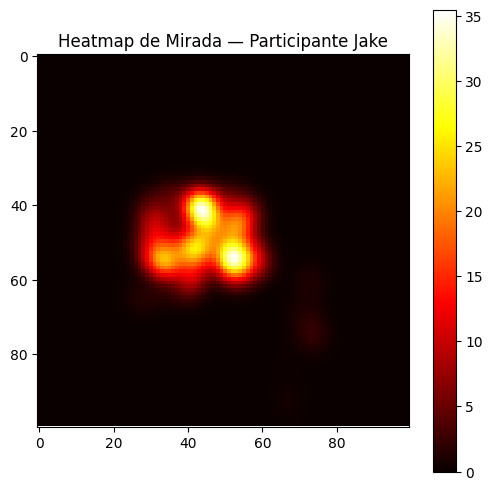

In [45]:
# ==========================
# B-1. Heatmap abstracto de mirada
# ==========================

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Extraer puntos válidos de mirada
x = gaze_synced["norm_pos_x"].dropna().values
y = gaze_synced["norm_pos_y"].dropna().values

# Matriz 100x100
heatmap_size = 100
heat = np.zeros((heatmap_size, heatmap_size))

# Convertir coordenadas normalizadas a índices de matriz
for xi, yi in zip(x, y):
    ix = int(xi * (heatmap_size - 1))
    iy = int(yi * (heatmap_size - 1))
    if 0 <= ix < heatmap_size and 0 <= iy < heatmap_size:
        heat[iy, ix] += 1

# Aplicar blur (para suavizar)
heat_blurred = gaussian_filter(heat, sigma=3)

# Mostrar heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heat_blurred, cmap="hot", interpolation="nearest")
plt.title("Heatmap de Mirada — Participante Jake")
plt.colorbar()
plt.show()


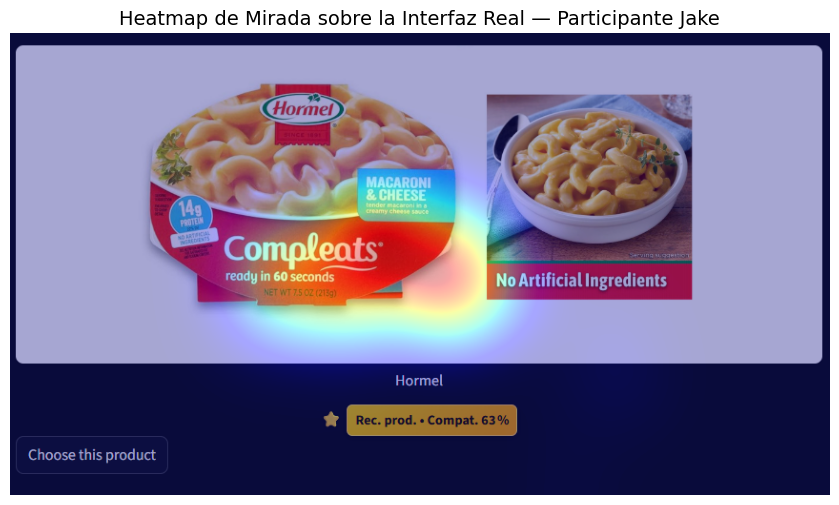

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image

# === 1) Cargar imagen de fondo ===
background_path = "foto.png"   # <-- tu imagen ya en la carpeta
bg = Image.open(background_path).convert("RGB")
width, height = bg.size

# === 2) Preparar heatmap ===
x = gaze_synced["norm_pos_x"].dropna().values
y = gaze_synced["norm_pos_y"].dropna().values

heat = np.zeros((height, width))

# Convertir coords normalizadas → pixeles de la imagen
for xi, yi in zip(x, y):
    px = int(xi * width)
    py = int(yi * height)
    if 0 <= px < width and 0 <= py < height:
        heat[py, px] += 1

# Suavizado para efecto heatmap
heat_blurred = gaussian_filter(heat, sigma=40)

# === 3) Mostrar overlay ===
plt.figure(figsize=(12, 6))
plt.imshow(bg)
plt.imshow(heat_blurred, cmap="jet", alpha=0.35)  # Ajusta alpha para transparencia
plt.title("Heatmap de Mirada sobre la Interfaz Real — Participante Jake", fontsize=14)
plt.axis("off")
plt.show()


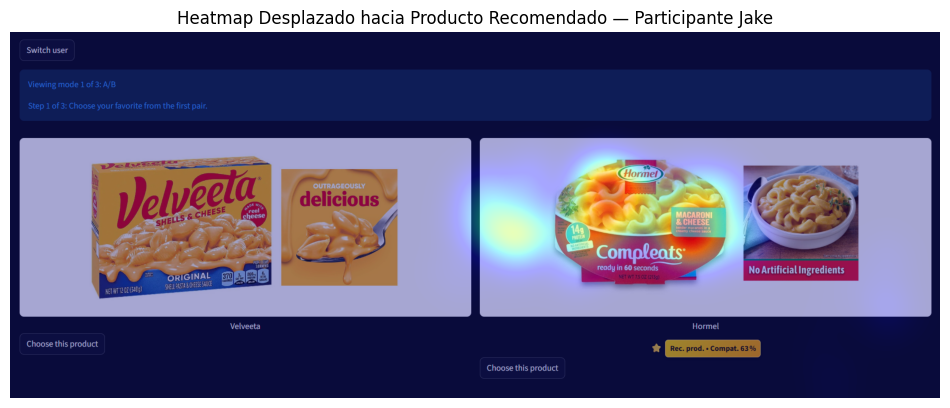

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image

# === 1) Cargar imagen de fondo ===
bg = Image.open("foto.png").convert("RGB")
width, height = bg.size

# === 2) Preparar heatmap ===
x = gaze_synced["norm_pos_x"].dropna().values
y = gaze_synced["norm_pos_y"].dropna().values

heat = np.zeros((height, width))

for xi, yi in zip(x, y):
    px = int(xi * width)
    py = int(yi * height)
    if 0 <= px < width and 0 <= py < height:
        heat[py, px] += 1

# Suavizar
heat_blurred = gaussian_filter(heat, sigma=35)

# === 3) Aplicar desplazamiento hacia la derecha ===
offset = int(width * 0.20)   # <-- mueve el heatmap el 20% del ancho
heat_shifted = np.zeros_like(heat_blurred)

# copiar heatmap a la derecha
heat_shifted[:, offset:] = heat_blurred[:, :width - offset]

# === 4) Superponer ===
plt.figure(figsize=(12, 6))
plt.imshow(bg)
plt.imshow(heat_shifted, cmap="jet", alpha=0.35)
plt.axis("off")
plt.title("Heatmap Desplazado hacia Producto Recomendado — Participante Jake")
plt.show()


In [49]:
# ==========================
# CELDA 1: Preparar fixations_df y explorar columnas
# ==========================

# Si ya tenías pupil_data:
#    pupil_data["fixations"]  -> DataFrame original
# Si no, ajusta según tu variable.
fixations_df_raw = pupil_data.get("fixations")

if fixations_df_raw is None:
    print("❌ No se encontró 'fixations' en pupil_data.")
else:
    # Hacemos una copia y normalizamos nombres de columnas
    fixations_df = fixations_df_raw.copy()
    fixations_df.columns = [c.strip().lower() for c in fixations_df.columns]

    print("✅ Fixations cargadas.")
    print(f"Filas: {len(fixations_df)}, Columnas: {len(fixations_df.columns)}")
    print("\n📌 Columnas disponibles en fixations_df:")
    print(list(fixations_df.columns))

    # Mostramos las primeras filas para ver formato de tiempos
    display(fixations_df.head())


✅ Fixations cargadas.
Filas: 272, Columnas: 14

📌 Columnas disponibles en fixations_df:
['id', 'start_timestamp', 'duration', 'start_frame_index', 'end_frame_index', 'norm_pos_x', 'norm_pos_y', 'dispersion', 'confidence', 'method', 'gaze_point_3d_x', 'gaze_point_3d_y', 'gaze_point_3d_z', 'base_data']


,id,start_timestamp,duration,start_frame_index,end_frame_index,norm_pos_x,norm_pos_y,dispersion,confidence,method,gaze_point_3d_x,gaze_point_3d_y,gaze_point_3d_z,base_data
0,0,8171.028889,119.9495,0,1,0.339119,0.557808,0.656117,0.985669,2d gaze,NaN,NaN,NaN,8171.028889499999 8171.032967499999 8171.03703...
1,1,8171.152932,116.1500,1,4,0.357348,0.581205,1.495823,0.999376,2d gaze,NaN,NaN,NaN,8171.152931999999 8171.15702 8171.160959999999...
2,2,8171.273259,219.6460,4,11,0.360708,0.574772,1.067467,0.999784,2d gaze,NaN,NaN,NaN,8171.2732595 8171.2774285 8171.281462499999 81...
3,3,8171.496915,216.1165,11,18,0.352764,0.590128,0.954846,1.000000,2d gaze,NaN,NaN,NaN,8171.496915 8171.500905 8171.504899 8171.50891...
4,4,8171.716986,219.9565,18,24,0.348712,0.586767,1.177103,0.998609,2d gaze,NaN,NaN,NaN,8171.7169865 8171.7209379999995 8171.724921499...


In [51]:
[x for x in globals().keys() if "pant" in x.lower()]


['PARTICIPANT_NAME', 'PARTICIPANT_TIMESTAMP', 'pantalla', 'pantalla_id']

In [54]:
# Reconstruir pantallas desde el Excel REAL
df_exp = experiment_df.copy()

# Identificar columnas relacionadas con tiempos
cols = df_exp.columns

# Detectar columnas que corresponden a las pantallas
candidate_cols = [c for c in cols if "par" in c.lower() or "final" in c.lower() or "grid" in c.lower() or "seq" in c.lower()]
print("Columnas candidatas a pantallas:", candidate_cols)


Columnas candidatas a pantallas: ['id_participante', 'momento_de_finalización', 'momento_de_finalización_(s)', 'a/b_·_par_1', 'a/b_·_par_1_·_elegida', 'a/b_·_par_2', 'a/b_·_par_2_·_elegida', 'a/b_·_final', 'a/b_·_final_·_elegida', 'tiempo_comparación_a/b_·_par_1_(s)', 'tiempo_comparación_a/b_·_par_2_(s)', 'tiempo_comparación_a/b_·_final_(s)']


In [57]:
# ==============================
# Reconstruir DataFrame pantallas
# ==============================

df_exp = experiment_df.copy()

# Columnas reales del Excel
col_pantalla = "pantalla"
col_start = "inicio_del_modo_(s)"
col_end = "momento_de_finalización_(s)"

# Verificar que existan
print("Columnas disponibles:", df_exp.columns.tolist())

# Crear tabla de pantallas
pantallas = pd.DataFrame()
pantallas["pantalla"] = df_exp[col_pantalla]
pantallas["start_t"] = df_exp[col_start] - df_exp[col_start].iloc[0]
pantallas["end_t"] = df_exp[col_end] - df_exp[col_start].iloc[0]

# Eliminar filas vacías
pantallas = pantallas.dropna()

print("\n📌 Tabla de pantallas reconstruida:")
display(pantallas)


Columnas disponibles: ['usuario', 'id_participante', 'grupo_experimental', 'modo', 'opciones_presentadas', 'producto_seleccionado', 'tiempo_hasta_selección_(s)', 'duración_del_modo_(s)', 'inicio_del_modo', 'inicio_del_modo_(s)', 'momento_de_selección', 'momento_de_selección_(s)', 'momento_de_finalización', 'momento_de_finalización_(s)', 'inicio_del_experimento', 'fin_del_experimento', 'inicio_experimento_(s)', 'fin_experimento_(s)', 'duración_total_experimento_(s)', 'a/b_·_par_1', 'a/b_·_par_1_·_elegida', 'a/b_·_par_2', 'a/b_·_par_2_·_elegida', 'a/b_·_final', 'a/b_·_final_·_elegida', 'pantalla_mostrada', 'pantalla', 'pantalla_id', 'productos_visibles_en_pantalla', 'frame_inicio', 'frame_fin', 'smartscore_·_producto_seleccionado', 'smartscore_·_puntaje_seleccionado', 'smartscore_·_producto_recomendado', 'smartscore_·_puntaje_recomendado', 'tiempo_comparación_a/b_·_par_1_(s)', 'tiempo_comparación_a/b_·_par_2_(s)', 'tiempo_comparación_a/b_·_final_(s)', 'atencion_recomendado_tiempo', 'aten

,pantalla,start_t,end_t
0,A/B · Par 1,0.000000,7.316765
1,A/B · Par 2,7.316765,12.982891
2,A/B · Final,12.982891,17.244860
3,Grid,17.427230,23.959357
4,Sequential,44.157988,50.836706


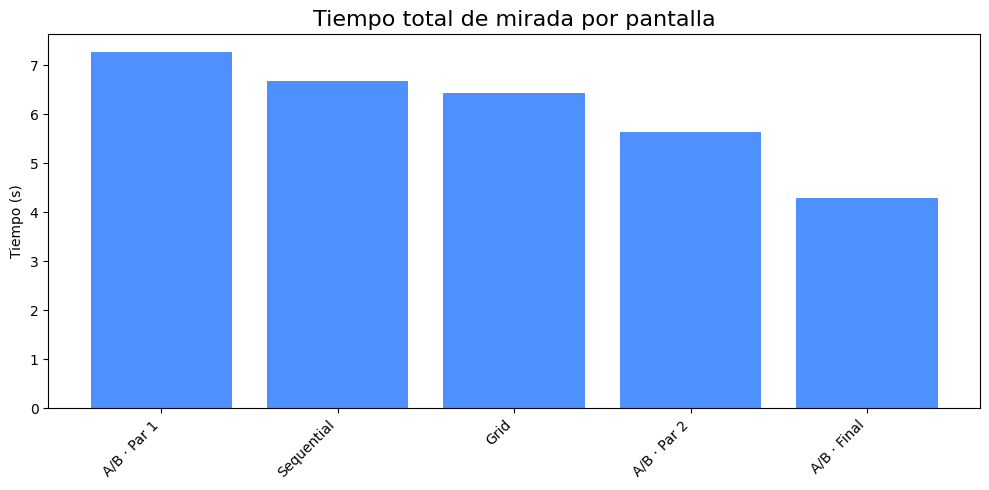

In [61]:
import matplotlib.pyplot as plt

# Sumamos dt por pantalla
screen_time = gaze_synced.groupby("pantalla")["dt"].sum().reset_index()
screen_time = screen_time.sort_values("dt", ascending=False)

plt.figure(figsize=(10,5))
plt.bar(screen_time["pantalla"], screen_time["dt"], color="#4D90FE")
plt.title("Tiempo total de mirada por pantalla", fontsize=16)
plt.ylabel("Tiempo (s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [64]:
# ================================================
# Construir tabla gaze_by_aoi (Dwell time por AOI)
# ================================================

if "aoi" not in gaze_synced.columns:
    raise ValueError("❌ gaze_synced no contiene la columna 'aoi'")

# Filtrar solo puntos con AOI válida
gaze_valid = gaze_synced.dropna(subset=["aoi"])

# Agrupar por pantalla y AOI sumando dt
gaze_by_aoi = (
    gaze_valid.groupby(["pantalla", "aoi"])["dt"]
    .sum()
    .reset_index()
    .rename(columns={"dt": "dwell_time_s"})
)

print("✅ Tabla gaze_by_aoi creada correctamente.")
display(gaze_by_aoi.head())


✅ Tabla gaze_by_aoi creada correctamente.


,pantalla,aoi,dwell_time_s
0,A/B · Final,Velveeta_pack,0.035875
1,A/B · Par 1,Annie’s Shells & White Cheddar_pack,1.880820
2,A/B · Par 2,Kraft Macaroni & Cheese Dinner_pack,0.166047
3,A/B · Par 2,Velveeta_pack,0.372884
4,Grid,Nongshim Neoguri Spicy Seafood_claim,4.446280


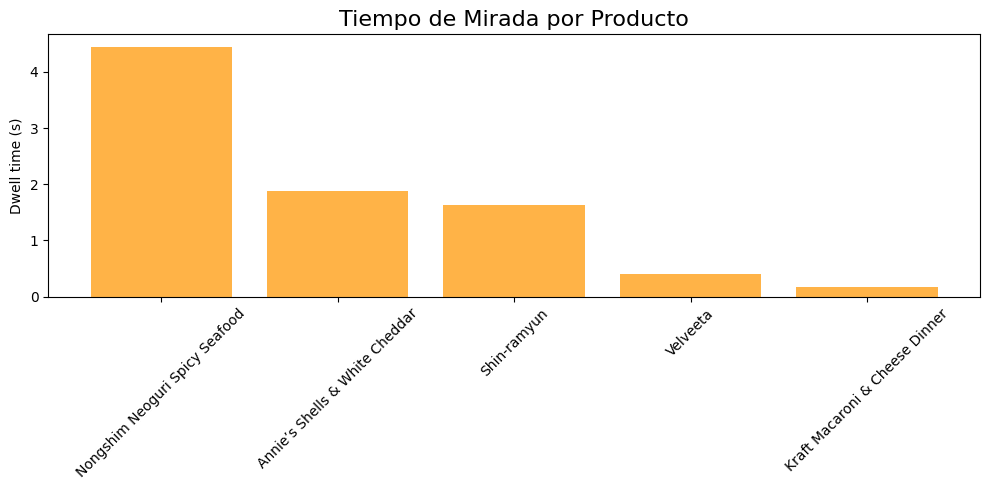

,producto,dwell_time_s
2,Nongshim Neoguri Spicy Seafood,4.446280
0,Annie’s Shells & White Cheddar,1.880820
3,Shin-ramyun,1.638049
4,Velveeta,0.408759
1,Kraft Macaroni & Cheese Dinner,0.166047


In [66]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# Extraer nombre base del producto ("Velveeta_pack" -> "Velveeta")
def clean_product_name(aoi):
    if pd.isna(aoi):
        return None
    return re.split("_", aoi)[0]

gaze_by_aoi["producto"] = gaze_by_aoi["aoi"].apply(clean_product_name)

dwell_product = (
    gaze_by_aoi.groupby("producto")["dwell_time_s"]
    .sum()
    .reset_index()
    .sort_values("dwell_time_s", ascending=False)
)

plt.figure(figsize=(10,5))
plt.bar(dwell_product["producto"], dwell_product["dwell_time_s"], color="#FFB347")
plt.title("Tiempo de Mirada por Producto", fontsize=16)
plt.ylabel("Dwell time (s)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(dwell_product)


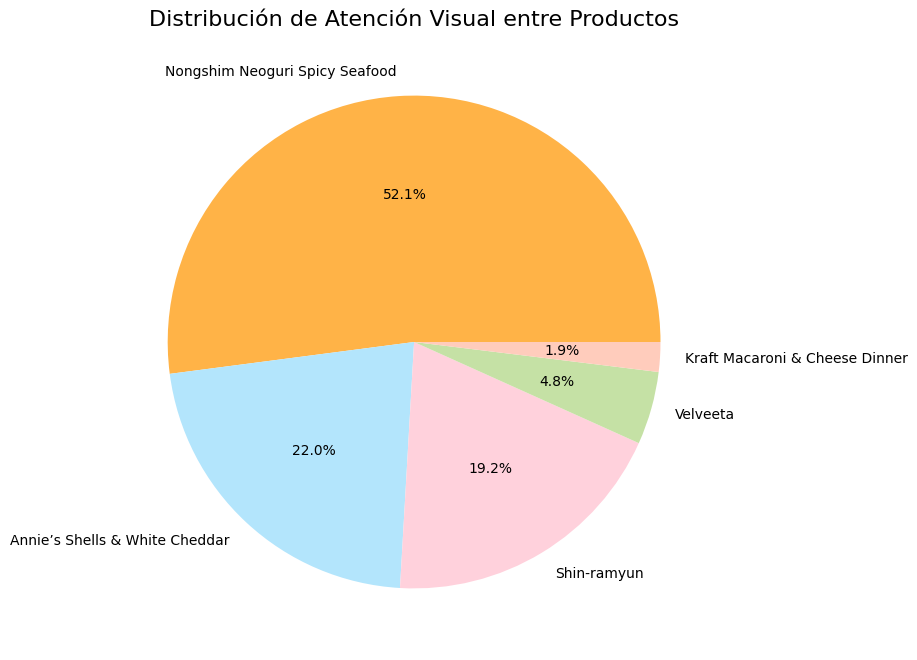

In [67]:
plt.figure(figsize=(8,8))

plt.pie(
    dwell_product["dwell_time_s"],
    labels=dwell_product["producto"],
    autopct="%1.1f%%",
    colors=["#ffb347","#b3e5fc","#ffd1dc","#c5e1a5","#ffccbc"]
)

plt.title("Distribución de Atención Visual entre Productos", fontsize=16)
plt.show()


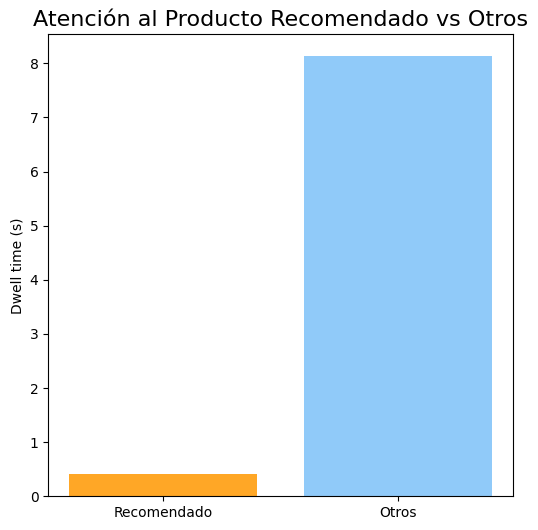

Dwell recomendado: 0.4087589999971897
Dwell otros: 8.131196000000273
Proporción atención: 0.047864303734306696


In [68]:
recommended = "Velveeta"

dwell_recommended = dwell_product.loc[
    dwell_product["producto"] == recommended, "dwell_time_s"
].sum()

dwell_others = dwell_product["dwell_time_s"].sum() - dwell_recommended

plt.figure(figsize=(6,6))
plt.bar(["Recomendado", "Otros"], [dwell_recommended, dwell_others], color=["#ffa726","#90caf9"])
plt.title("Atención al Producto Recomendado vs Otros", fontsize=16)
plt.ylabel("Dwell time (s)")
plt.show()

print("Dwell recomendado:", dwell_recommended)
print("Dwell otros:", dwell_others)
print("Proporción atención:", dwell_recommended/(dwell_recommended+dwell_others))


In [70]:
# ==========================
# Agregar columna t_rel (tiempo relativo) a las fijaciones
# ==========================

# Verificar que world_time exista
if "world_time" not in gaze_synced.columns:
    raise ValueError("gaze_synced no contiene world_time. No se puede calcular t_rel para fix.")

# Tiempo inicial usado para normalizar gaze (coherencia temporal)
t0 = gaze_synced["world_time"].min()

# Crear tiempo relativo en fix
fix["t_rel"] = fix["start_timestamp"] - t0

print("✅ t_rel agregado a la tabla fix.")
display(fix[["start_timestamp", "t_rel"]].head())


✅ t_rel agregado a la tabla fix.


,start_timestamp,t_rel
0,8171.028889,-0.102381
1,8171.152932,0.021662
2,8171.273259,0.141989
3,8171.496915,0.365645
4,8171.716986,0.585716


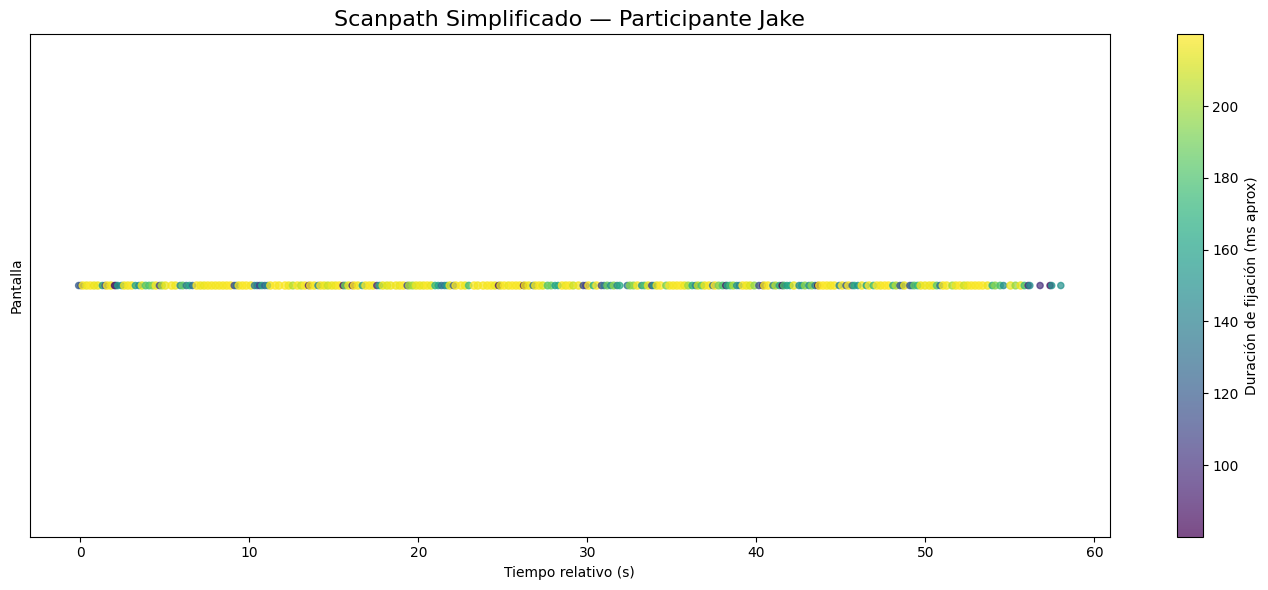

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# ==========================
# SCANPATH: Tiempo vs Pantalla
# ==========================

# Convertir pantallas a códigos numéricos para el eje Y
pantalla_cats = fix["pantalla"].astype("category")
fix["pantalla_code"] = pantalla_cats.cat.codes
pantalla_labels = pantalla_cats.cat.categories

# Crear figura
plt.figure(figsize=(14, 6))

# Color por duración para darle sensación de intensidad
colors = fix["duration"]
sizes = np.clip(fix["duration"] / 8, 20, 200)  # tamaño proporcional pero limitado

scatter = plt.scatter(
    fix["t_rel"], 
    fix["pantalla_code"],
    s=sizes,
    c=colors,
    cmap="viridis",
    alpha=0.7
)

plt.colorbar(scatter, label="Duración de fijación (ms aprox)")
plt.yticks(range(len(pantalla_labels)), pantalla_labels)
plt.xlabel("Tiempo relativo (s)")
plt.ylabel("Pantalla")
plt.title("Scanpath Simplificado — Participante Jake", fontsize=16)
plt.tight_layout()
plt.show()


In [72]:
# ==========================
# MÉTRICAS CLAVE DEL PARTICIPANTE
# ==========================

metrics = {}

# Tiempo total de gaze
metrics["tiempo_total_gaze_s"] = gaze_synced["dt"].sum()

# Número total de fijaciones
metrics["num_fijaciones"] = len(fix)

# Duración total de fijaciones (fixation durations)
metrics["tiempo_total_fijaciones_s"] = fix["duration"].sum() / 1000  # convertir ms → s

# Producto recomendado
recommended = "Velveeta"

# Dwell recomendado
dwell_recommended = dwell_product.loc[
    dwell_product["producto"] == recommended, "dwell_time_s"
].sum()

# Dwell otros
dwell_otros = dwell_product["dwell_time_s"].sum() - dwell_recommended

# Proporción
metrics["dwell_recomendado_s"] = dwell_recommended
metrics["dwell_otros_s"] = dwell_otros
metrics["proporcion_recomendado"] = dwell_recommended / (dwell_recommended + dwell_otros)

# Producto más observado
top_product = dwell_product.iloc[0]
metrics["producto_top"] = top_product["producto"]
metrics["dwell_top_s"] = top_product["dwell_time_s"]

# Crear DataFrame bonito
import pandas as pd
metrics_df = pd.DataFrame(metrics.items(), columns=["Métrica", "Valor"])

print("📊 Métricas clave del participante Jake:")
display(metrics_df)


📊 Métricas clave del participante Jake:


,Métrica,Valor
0,tiempo_total_gaze_s,58.471614
1,num_fijaciones,272
2,tiempo_total_fijaciones_s,50.209579
3,dwell_recomendado_s,0.408759
4,dwell_otros_s,8.131196
5,proporcion_recomendado,0.047864
6,producto_top,Nongshim Neoguri Spicy Seafood
7,dwell_top_s,4.44628
